# Financial Data Analysis and Fraud Detection 

[kaggle project](https://www.kaggle.com/ntnu-testimon/paysim1)<br>
<br>
Dataset Download<br>
* [kaggle](https://www.kaggle.com/ntnu-testimon/paysim1/downloads/paysim1.zip)

## Dataset Description

This dataset is a log of transfer records come from one mobile payment company, 
For a transfer record, predict whether it is fraudulent
Data column description：<br>
* step: time unit(h)
* type: transfer type
* amount: transfer quantity
* nameOrig: transfer origin name
* oldbalanceOrg: balance before transfer of transfer origin name
* newbalanceOrig: balance after transfer of transfer origin name
* nameDest: transfer receiver  
* oldbalanceDest: balance of receiver before transfer. Note: When the payee is a merchant (the payee that starts with M), this information is not available.
* newbalanceDest: balance of receiver after transfer. Note: When the payee is a merchant (the payee that starts with M), this information is not available.
* isFraud: This transfer is fraudulent. Fraud here refers to controlling the customer's account, then transferring all of its amount to another account, and finally withdrawing all
* isFlaggedFraud: The business model is designed to control large transfers and is marked as illegal. Here, illegal operation means that in a single transfer, the transfer amount exceeds 200,000。

## 0. Data preparation 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from scipy.stats import skew, boxcox
import zipfile
import os

In [3]:
raw_data = pd.read_csv('dataset.csv')
# Dataset information
print('View dataset: ')
print(raw_data.head())

print('Data describe: ')
print(raw_data.describe())

print('Dataset basic information: ')
print(raw_data.info())

View dataset: 
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
Data describe: 
               step        amount  oldbalanceOrg  newbalanceOrig  \
count 

## 1. Exploratory Data Analysis 

Summary of transfer type: 
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


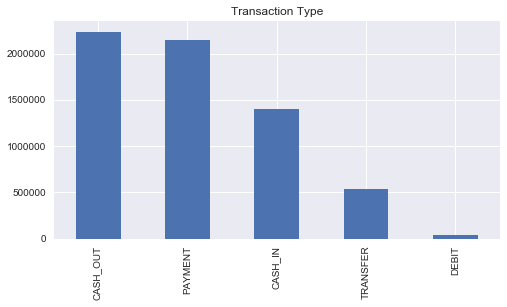

In [4]:
print('Summary of transfer type: ')
print(raw_data['type'].value_counts())   ########   To see the value count of one column of dataset   ##########
fig, ax = plt.subplots( figsize = (8,4))
raw_data['type'].value_counts().plot(kind = 'bar', title = 'Transaction Type', ax=ax, figsize=(8,4))
plt.show()

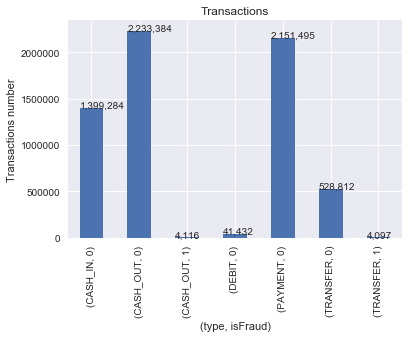

In [5]:
ax = raw_data.groupby(['type','isFraud']).size().plot(kind='bar')
ax.set_title("Transactions")
ax.set_xlabel('(type, isFraud)')
ax.set_ylabel('Transactions number')

for p in ax.patches:
    ax.annotate((format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    #format makes it iterabe, ',d'means digit notation per 1000, in order to using d, the data must be redifined as int

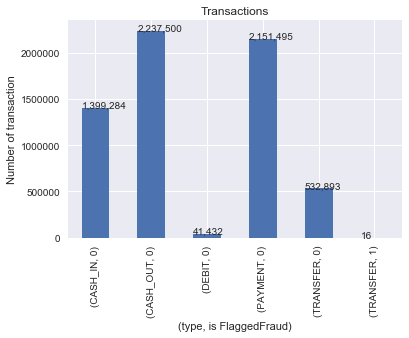

In [6]:
ax = raw_data.groupby(['type','isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("Transactions")
ax.set_xlabel('(type, is FlaggedFraud)')
ax.set_ylabel('Number of transaction')

for p in ax.patches:
    ax.annotate((format(int(p.get_height()), ',d')), (p.get_x(),p.get_height()))

D:\Annaconda\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


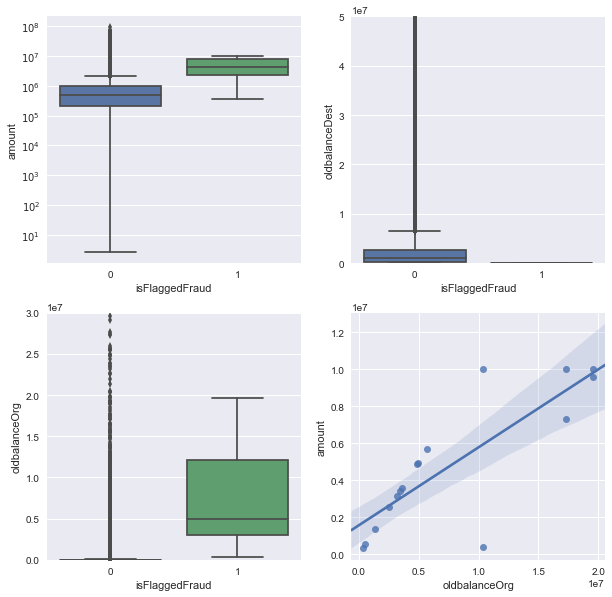

In [7]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
transfer_data = raw_data[raw_data['type'] == 'TRANSFER']

a = sns.boxplot(x='isFlaggedFraud', y='amount', data=transfer_data, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x='isFlaggedFraud', y='oldbalanceDest', data=transfer_data, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x='isFlaggedFraud', y='oldbalanceOrg', data=transfer_data, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))
d = sns.regplot(x='oldbalanceOrg', y='amount', data=transfer_data[transfer_data['isFlaggedFraud']==1], ax=axs[1][1])
##### assume axis x and y relationship, based on the dataset columns  ########
plt.show()

## 2. Data Processing 

In [8]:
used_data = raw_data[(raw_data['type'] == 'TRANSFER')| (raw_data['type'] == 'CASH_OUT')]  #Select particular column value
used_data.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)  #### Reindex dataset  
used_data = used_data.reset_index(drop=True)

type_label_encoder = preprocessing.LabelEncoder()
type_category = type_label_encoder.fit_transform(used_data['type'])    #### Encoder with 0 or 1  ########
used_data['typeCategory'] = type_category   ##### Assume a new column

used_data.head()

D:\Annaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,typeCategory
0,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,1
1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0
2,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,0
3,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,1
4,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


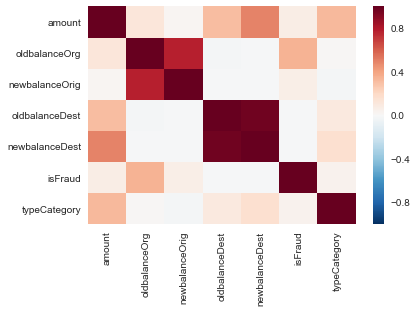

In [9]:
sns.heatmap(used_data.corr())  #### Correlation between columns

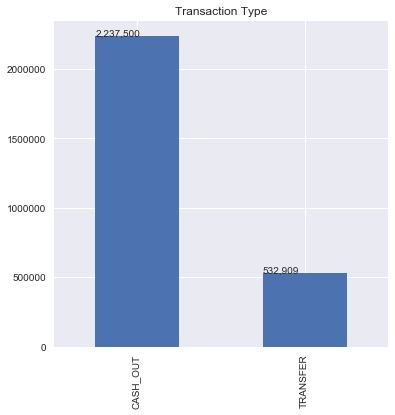

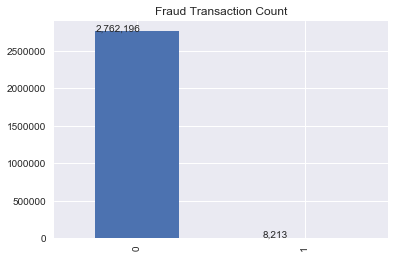

In [10]:
ax = used_data['type'].value_counts().plot(kind='bar',title='Transaction Type', figsize=(6,6))
for p in ax.patches:
    ax.annotate((format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
plt.show()

ax = pd.value_counts(used_data['isFraud'], sort = True).sort_index().plot(kind='bar',title='Fraud Transaction Count')
for p in ax.patches:
    ax.annotate((format(int(p.get_height()),',d')), (p.get_x(), p.get_height()))
plt.show()    

In [11]:
feature_names = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'typeCategory']
X = used_data[feature_names]
y = used_data['isFraud']
X.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,typeCategory
0,181.00,181.0,0.0,0.0,0.00,1
1,181.00,181.0,0.0,21182.0,0.00,0
2,229133.94,15325.0,0.0,5083.0,51513.44,0
3,215310.30,705.0,0.0,22425.0,0.00,1
4,311685.89,10835.0,0.0,6267.0,2719172.89,1


In [12]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: isFraud, dtype: int64

In [13]:
#### The number of fraud data
# 处理不平衡数据
# 欺诈记录的条数
fraud_indices = used_data[used_data['isFraud'] == 1].index.values
fraud_indices
nonfraud_indices = used_data[used_data['isFraud'] == 0].index
nonfraud_indices

Int64Index([      2,       3,       4,       5,       6,       7,       8,
                  9,      10,      11,
            ...
            2770103, 2770104, 2770105, 2770106, 2770107, 2770108, 2770109,
            2770110, 2770111, 2770112],
           dtype='int64', length=2762196)

In [17]:
number_records_fraud = len(used_data[used_data['isFraud'] == 1])
#### The number of fraud data
fraud_indices = used_data[used_data['isFraud'] == 1].index.values
fraud_indices
nonfraud_indices = used_data[used_data['isFraud'] == 0].index.values
nonfraud_indices 


array([      2,       3,       4, ..., 2770110, 2770111, 2770112],
      dtype=int64)

In [18]:
#random_nonfraud_indices = np.random.choice(nonfraud_indices, number_records_fraud)
random_nonfraud_indices =nonfraud_indices
### Select non-fraud indices randomly# 随机选取相同数量的非欺诈记录
random_nonfraud_indices = np.array(random_nonfraud_indices)
random_nonfraud_indices
# 整合两类样本的索引
under_sample_indices = np.concatenate([fraud_indices, nonfraud_indices])

under_sample_indices

array([      0,       1,     123, ..., 2770110, 2770111, 2770112],
      dtype=int64)

In [19]:
under_sample_data = used_data.iloc[under_sample_indices, :]
######   Select the rows by previous steps  #######
under_sample_data.head(5)

X_undersample = under_sample_data[feature_names].values
y_undersample = under_sample_data['isFraud'].values
########     Propotion    ###################
print("非欺诈记录比例: ", len(under_sample_data[under_sample_data['isFraud'] == 0]) / len(under_sample_data))
print("欺诈记录比例: ", len(under_sample_data[under_sample_data['isFraud'] == 1]) / len(under_sample_data))
print("采样记录数: ", len(under_sample_data))

非欺诈记录比例:  0.9970354557756634
欺诈记录比例:  0.002964544224336551
采样记录数:  2770409


## 3. Modeling 

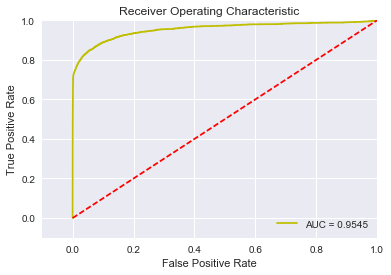

In [27]:
# 选用逻辑回归模型进行预测
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state = 0 )

lr_model = LogisticRegression()  #####  Call the model
lr_model.fit(X_train, y_train)  ##### Train the model

y_pred_score = lr_model.decision_function(X_test)  ##### Using model on test dataset

fpr, tpr, aa = roc_curve(y_test, y_pred_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'y',label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])####   Make the graph easy to see
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Roc and Auc curve
https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5